In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
from scipy import signal
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Load data

In [2]:
data1 = sio.loadmat(r'./Salinas_corrected.mat')
data2 = sio.loadmat(r'./Salinas_gt.mat')
print(data1.keys())
print(data2.keys())

dict_keys(['__header__', '__version__', '__globals__', 'salinas_corrected'])
dict_keys(['__header__', '__version__', '__globals__', 'salinas_gt'])


In [3]:
salinas_img = data1['salinas_corrected']
salinas_labels = data2['salinas_gt']
print("Salinas shape: {}".format(salinas_img.shape))

Salinas shape: (512, 217, 204)


# Plot the curve of one sample

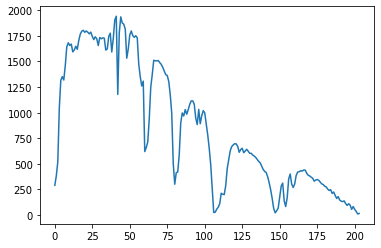

In [4]:
# get any position 
pos = [0,1]
feature = salinas_img[pos[0],pos[1],:]
plt.plot(feature)

# Data count of each class

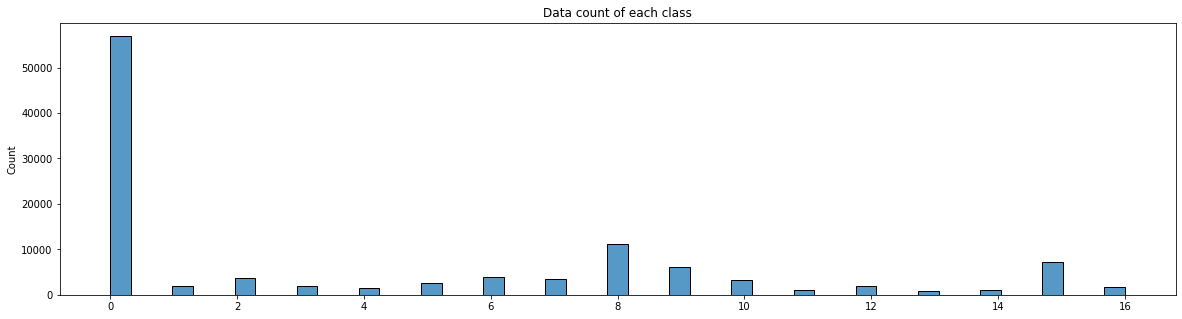

In [5]:
plt.figure(figsize=(20,5))
ax_salinas = sns.histplot(salinas_labels.flatten())
plt.title("Data count of each class")
plt.show()

# Reshape the data

In [6]:
X_salinas = salinas_img.reshape((-1, salinas_img.shape[-1])) # reshaping the HSI as a 2D matrix
y_gt = salinas_labels.ravel()
print("Salinas shape: {}".format(X_salinas.shape))

Salinas shape: (111104, 204)


# Rescale the data into range (0,1)

# PCA

In [7]:
#this function is from "tools.py" in "https://github.com/drguigui1/HSI-Classification/blob/7702cd8266853165ff7e62e36fc2d907846c7269/src/7%20-%20Random_forest_classifier.ipynb"
print("Fitting the PCA")
pca_model = PCA()
pca_model.fit(X_salinas)
var_cumsum = pca_model.explained_variance_ratio_.cumsum()
num_useful_feature = len(var_cumsum[var_cumsum <= 0.997])
print("Number of components Salinas:")
print(num_useful_feature) 

Fitting the PCA
Number of components Salinas:
4


The first graph shows the variance ratio of features(PCA) and the second graph is the cumulative sum of variance ratio

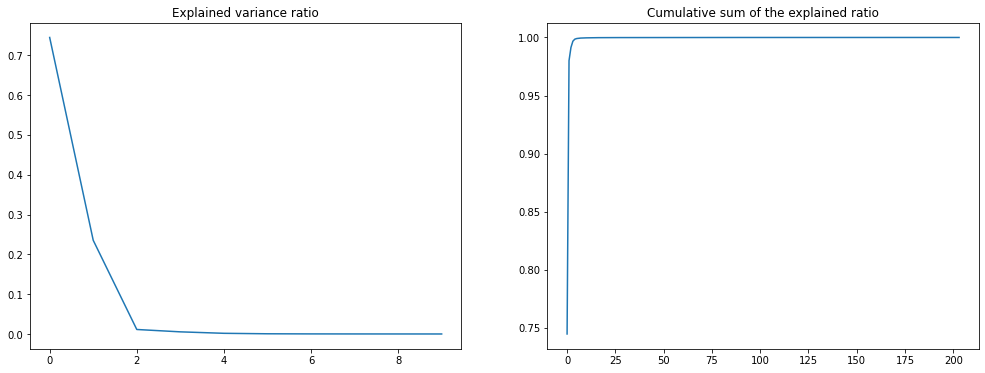

In [8]:
#this function is from "notebook.py" from https://notebooks.githubusercontent.com/view/ipynb?browser=edge&color_mode=auto&commit=fae244fbe6dd08dc1a4d336dc326b05a84429197&device=unknown_device&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f4c69306e4d6f3073652f6879706572737065637472616c5f696d6c2f666165323434666265366464303864633161346433333664633332366230356138343432393139372f50726f6a6563742e6970796e62&logged_in=true&nwo=Li0nMo0se%2Fhyperspectral_iml&path=Project.ipynb&platform=windows&repository_id=360174211&repository_type=Repository&version=96#load-data
plt.figure(figsize=(17,6))
plt.subplot(1, 2, 1)
plt.plot(pca_model.explained_variance_ratio_[:10])
plt.title("Explained variance ratio")

plt.subplot(1, 2, 2)
plt.title("Cumulative sum of the explained ratio")
plt.plot(var_cumsum)
plt.show()

Feature extraction

In [9]:
pca_model = PCA(n_components = num_useful_feature)
pca_model.fit(X_salinas)
X_salinas_reduced_pca = pca_model.transform(X_salinas)
print(X_salinas_reduced_pca.shape)

(111104, 4)


# Remove the background

In [10]:
X_salinas_reduced_pca = np.delete(X_salinas_reduced_pca, np.where(y_gt == 0), axis = 0)
y = np.delete(y_gt, np.where(y_gt == 0))

print(X_salinas_reduced_pca.shape)
print(y.shape)

(54129, 4)
(54129,)


# Rescale the data into range (0,1)

In [11]:
# setup the MinMaxScaler 
scaler = MinMaxScaler(feature_range=(0, 1))
# Normalization: transform the dataset into the range [0,1]
X_salinas_01 = scaler.fit_transform(X_salinas_reduced_pca)

# Splite data into train and test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_salinas_01, y, test_size=0.25, random_state=42)

In [13]:
print("Train shape: {}".format(X_train.shape))
print("Train labels shape: {}".format(y_train.shape))
print("Test shape: {}".format(X_test.shape))
print("Test labels shape: {}".format(y_test.shape))

Train shape: (40596, 4)
Train labels shape: (40596,)
Test shape: (13533, 4)
Test labels shape: (13533,)


# K-Fold & Grid Search to Get best parameters

In [14]:
#Model instantiation
svc = SVC()

In [15]:
#Set the value range of max_iter_range
max_iter_range = [(i + 1) * 1000 for i in range(4)]
print(max_iter_range)

[1000, 2000, 3000, 4000]


In [16]:
#Set the number of feature (PCA)
param_n_components = [num_useful_feature]
print(param_n_components)

[4]


In [17]:
#this function is from "notebook.py" from https://notebooks.githubusercontent.com/view/ipynb?browser=edge&color_mode=auto&commit=fae244fbe6dd08dc1a4d336dc326b05a84429197&device=unknown_device&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f4c69306e4d6f3073652f6879706572737065637472616c5f696d6c2f666165323434666265366464303864633161346433333664633332366230356138343432393139372f50726f6a6563742e6970796e62&logged_in=true&nwo=Li0nMo0se%2Fhyperspectral_iml&path=Project.ipynb&platform=windows&repository_id=360174211&repository_type=Repository&version=96#load-data
grid_params = {
    'pca__n_components': param_n_components,
    'svc__max_iter': max_iter_range,
    'svc__C': [1, 100, 250, 500]
}

In "GridSearchCV()", the k-fold method is used, since the default value of the parameter "cv" is 5, the 5-fold method is used to divide part of the training data into validation data to evaluate the training effect of the model and select the parameters.

In [18]:
#this function is from "notebook.py" from https://notebooks.githubusercontent.com/view/ipynb?browser=edge&color_mode=auto&commit=fae244fbe6dd08dc1a4d336dc326b05a84429197&device=unknown_device&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f4c69306e4d6f3073652f6879706572737065637472616c5f696d6c2f666165323434666265366464303864633161346433333664633332366230356138343432393139372f50726f6a6563742e6970796e62&logged_in=true&nwo=Li0nMo0se%2Fhyperspectral_iml&path=Project.ipynb&platform=windows&repository_id=360174211&repository_type=Repository&version=96#load-data
def grid_search(clf, X, y, grid_params, /, *, n_jobs=-1, verbose=4):
    # Create the gridsearch
    # Cross validation gridsearch
    gs = GridSearchCV(clf, grid_params, n_jobs=8, verbose=4)
    print("---- Start search ----")
    gs.fit(X, y)
    print("---- Search finished ----")
    print("Best parameter (CV score=%0.3f): " % gs.best_score_)
    print(gs.best_params_)
    return gs.best_params_

In [19]:
#Make sure the steps of the transformation sequence
pipe_svc_with = Pipeline(steps=[('pca', pca_model),
                                ('svc', svc)])


In [20]:
#find the best parameter
best_params = grid_search(pipe_svc_with, X_train, y_train, grid_params) 

---- Start search ----
Fitting 5 folds for each of 16 candidates, totalling 80 fits
---- Search finished ----
Best parameter (CV score=0.897): 
{'pca__n_components': 4, 'svc__C': 1, 'svc__max_iter': 4000}


C:\ProgramData\Anaconda3\envs\jyc\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [21]:
#Get the best parameter
svc = SVC(random_state=2727,
                max_iter=best_params['svc__max_iter'],
                C=best_params['svc__C'])

In [22]:
#Fit the model
pipe_svc_with.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=4)), ('svc', SVC())])

Test accuracy of this model

In [23]:
#Get the test score of the model
score = pipe_svc_with.score(X_test,y_test)
print("The test score is")
print(score)

The test score is
0.8966230695337324


Final accuracy of this model

In [24]:
#Get the final score of the model
total_preds_salinas = pipe_svc_with.predict(X_salinas_01)
total_preds_salinas_score = accuracy_score(y, total_preds_salinas)
print("The final accuracy of this model is {}".format(total_preds_salinas_score))

The final accuracy of this model is 0.897762751944429


# Result comparison

In [25]:
#Establish the index of 16 labels 
idx = np.argwhere(salinas_labels.flatten() != 0).flatten()

In [26]:
salinas_preds_img = np.zeros((salinas_img.shape[0] * salinas_img.shape[1]))
#Passing prediction data into an image
salinas_preds_img[idx] = total_preds_salinas
salinas_preds_img = salinas_preds_img.reshape(((salinas_img.shape[0], salinas_img.shape[1])))

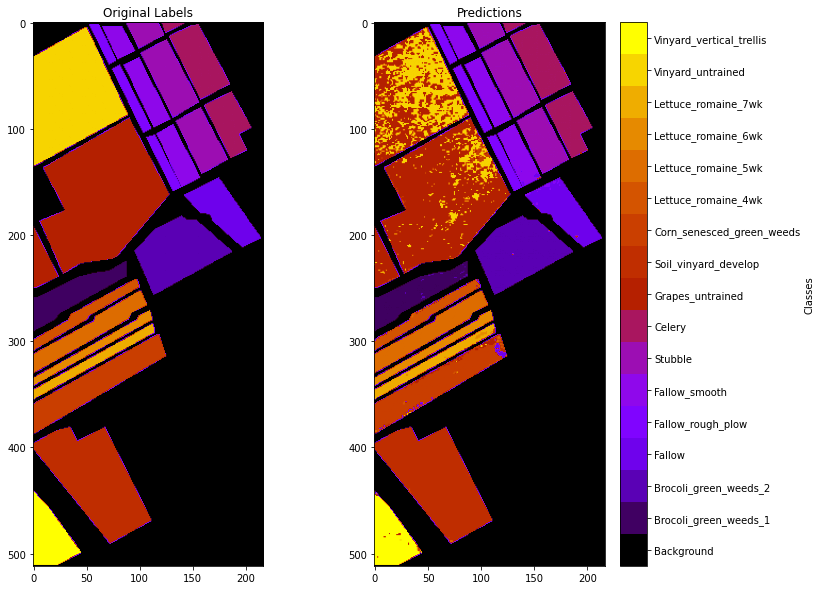

In [27]:
global GROUND_TRUTH
global NUM_CLASSES
#Establishe the name of labels
GROUND_TRUTH = ['Background', 'Brocoli_green_weeds_1', 'Brocoli_green_weeds_2', 'Fallow', 'Fallow_rough_plow',
                        'Fallow_smooth', 'Stubble', 'Celery', 'Grapes_untrained', 'Soil_vinyard_develop',
                        'Corn_senesced_green_weeds', 'Lettuce_romaine_4wk', 'Lettuce_romaine_5wk',
                        'Lettuce_romaine_6wk', 'Lettuce_romaine_7wk', 'Vinyard_untrained', 'Vinyard_vertical_trellis']
NUM_CLASSES = len(GROUND_TRUTH) - 1

plt.figure(figsize=(12,10))

plt.subplot(1, 2, 1)
plt.title('Original Labels')
plt.imshow(salinas_labels,cmap='gnuplot')

plt.subplot(1, 2, 2)
plt.title('Predictions')
plt.imshow(salinas_preds_img,cmap='gnuplot')

cbar = plt.colorbar(label='Classes', boundaries=(np.arange(NUM_CLASSES + 2) - 0.5))
cbar.set_ticks(np.arange(NUM_CLASSES + 1))
cbar.set_ticklabels(GROUND_TRUTH)
plt.show()